#Generation of a new Datase : Artficial 10k

The objetcive here was to generate a new 10k dataset from the 2.1M (HTS) dataset. We aimed to generate a dataset with the good docking scores and as divserse as possible. We used three diffrent technique to obtained a satisfactory dataset named "Database_Lucas3_10k".

In [ ]:
!pip install torch torchvision torchaudio
!pip install configargparse
!pip install h5py
!pip install numpy
!pip install -U ray[default]>=1.11
!pip install ray
!pip install rdkit
!pip install pytorch-lightning
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-addons
!pip install tqdm
!pip install umap-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install git+https://github.com/Nohalyan/molpal

  Cloning https://github.com/Nohalyan/molpal to /tmp/pip-req-build-yr4ayhfw
  Running command git clone --filter=blob:none --quiet https://github.com/Nohalyan/molpal /tmp/pip-req-build-yr4ayhfw
  Resolved https://github.com/Nohalyan/molpal to commit bc77cc89c2657e7ef24ed43ac2ce233cada1c3ce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for molpal: filename=molpal-0.1.dev770+gbc77cc8-py3-none-any.whl size=118486 sha256=4b0542ab17364278b13d2245ace9f0b2fed5ad44fe0d6e95e4529d533eae1b40
  Stored in directory: /tmp/pip-ephem-wheel-cache-9wt7xsa6/wheels/64/c3/76/25c86478ee6049d91fa40818a3acbe7fd16e978d033808e7c7
Successfully built molpal


In [ ]:
import pandas as pd
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!git clone https://github.com/Nohalyan/molpal.git
%ls

Cloning into 'molpal'...
remote: Enumerating objects: 4565, done.
remote: Counting objects: 100% (648/648), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 4565 (delta 395), reused 557 (delta 347), pack-reused 3917
Receiving objects: 100% (4565/4565), 121.52 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (3020/3020), done.
'=1.11'   molpal/   sample_data/


In [ ]:
from molpal.acquirer import Acquirer
from molpal.featurizer import Featurizer
from molpal.models import Model
from molpal.objectives import Objective
from molpal.pools import pool
from molpal.exceptions import IncompatibilityError, InvalidExplorationError
from molpal.explorer import Explorer
import numpy as np
import pandas as pd
import random
import more_itertools as mit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity

In [ ]:
df = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")
df.head()

,smiles,score
0,O=C(Nc1cc(Cl)ccc1C(=O)c1ccccc1)c1cccc(Nc2nc(-c...,-12.7
1,CC1(C)[C@@H]2CC[C@]13CS(=O)(=O)N(C(=O)CCc1ccnc...,-12.6
2,O=C(NN=C1c2ccccc2-c2ccccc21)c1cccc(NN=C2c3cccc...,-12.3
3,O=S(=O)(c1ccc2ccccc2c1)N1CCN(c2nnc(-c3ccccc3)c...,-12.3
4,O=C(COC(=O)c1c2c(nc3ccccc13)CCC2)Nc1ccc2c(c1)C...,-12.2


In [ ]:
top_1_percent = df.nsmallest(int(len(df) * 0.01), 'score')
top_1_percent

,smiles,score
0,O=C(Nc1cc(Cl)ccc1C(=O)c1ccccc1)c1cccc(Nc2nc(-c...,-12.7
1,CC1(C)[C@@H]2CC[C@]13CS(=O)(=O)N(C(=O)CCc1ccnc...,-12.6
2,O=C(NN=C1c2ccccc2-c2ccccc21)c1cccc(NN=C2c3cccc...,-12.3
3,O=S(=O)(c1ccc2ccccc2c1)N1CCN(c2nnc(-c3ccccc3)c...,-12.3
4,O=C(COC(=O)c1c2c(nc3ccccc13)CCC2)Nc1ccc2c(c1)C...,-12.2
...,...,...
21038,Cc1ccc(C2=Nc3nc(-c4ccccc4)cn3C(c3ccc(F)cc3)C2)cc1,-10.0
21039,O=C(NCC(=O)N1CCCC1)c1ccc2noc(-c3ccccc3)c2c1,-10.0
21040,Cc1ccc(S(=O)(=O)NCc2ccc(C(=O)Nc3cccc(N4CCCC4=O...,-10.0
21041,COc1ccc(C2CC(c3ccc4ccccc4c3)=NN2C(=O)CN2CCCC(C...,-10.0


# 1.1 Fisrt Attempt : Tanimoto

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Load your dataset (replace 'your_dataset.csv' with your actual file)
# Assume the SMILES strings are in a column named 'smiles'
df = top_1_percent
smiles_list = df['smiles'].tolist()

# Generate molecular fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in smiles_list]

# Calculate the Tanimoto dissimilarity matrix (1 - similarity)
num_mols = len(fps)
dissimilarity_matrix = np.zeros((num_mols, num_mols))

for i in range(num_mols):
    for j in range(i + 1, num_mols):
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        dissimilarity_matrix[i, j] = 1 - sim
        dissimilarity_matrix[j, i] = 1 - sim

# Perform clustering to ensure diversity
distance_matrix = squareform(dissimilarity_matrix)  # Convert to condensed distance matrix
clustering = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='average')
clusters = clustering.fit_predict(dissimilarity_matrix)

# Select one representative molecule from each cluster
representative_indices = []
for cluster_id in range(100):
    cluster_indices = np.where(clusters == cluster_id)[0]
    if len(cluster_indices) > 0:
        # Select the molecule with the maximum average dissimilarity within the cluster
        cluster_dissimilarities = dissimilarity_matrix[cluster_indices][:, cluster_indices]
        avg_dissimilarities = np.mean(cluster_dissimilarities, axis=1)
        representative_idx = cluster_indices[np.argmax(avg_dissimilarities)]
        representative_indices.append(representative_idx)

# Convert to a more readable format
most_dissimilar_molecules = [(smiles_list[idx], idx) for idx in representative_indices]

# Print the 100 most dissimilar molecules
for mol in most_dissimilar_molecules:
    print(mol)



In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

# Example list of SMILES strings
smiles_list = []
for mol, idx in most_dissimilar_molecules:
  smiles_list.append(mol)



# Load your dataframe (replace 'data_f.csv' with your actual file)
# Assume the SMILES strings are in a column named 'smiles' in the dataframe

df_2M_smiles = df_2M['smiles'].tolist()

# Generate molecular fingerprints for the dataset
df_2M_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in df_2M_smiles]

# Function to find top 100 most similar molecules for a given query_smiles
def find_top_100_similar(query_smiles, data_f_fps, data_f_smiles, exclude_indices):
    query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(query_smiles), 2, nBits=2048)
    similarities = []
    for idx, fp in enumerate(data_f_fps):
        if idx not in exclude_indices:
            sim = DataStructs.TanimotoSimilarity(query_fp, fp)
            similarities.append((sim, idx))

    # Sort by similarity in descending order and take the top 100
    top_100 = sorted(similarities, key=lambda x: x[0], reverse=True)[:100]
    top_100_indices = [idx for _, idx in top_100]
    return top_100_indices

# Initialize a set to keep track of used indices to avoid duplicates
used_indices = set()

# Dictionary to store the results for each query SMILES
results = {}

#1.2 Second attempt: Dice Similarity

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Charger le dataset (remplacer 'your_dataset.csv' par le fichier réel)
# Supposons que les chaînes SMILES sont dans une colonne nommée 'smiles'
df = top_1_percent
smiles_list = df['smiles'].tolist()

# Générer des empreintes moléculaires
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in smiles_list]

# Calculer la matrice de dissimilarité Dice (1 - similarité)
num_mols = len(fps)
dissimilarity_matrix = np.zeros((num_mols, num_mols))

for i in range(num_mols):
    for j in range(i + 1, num_mols):
        sim = DataStructs.DiceSimilarity(fps[i], fps[j])
        dissimilarity_matrix[i, j] = 1 - sim
        dissimilarity_matrix[j, i] = 1 - sim

# Effectuer le clustering pour assurer la diversité
distance_matrix = squareform(dissimilarity_matrix)  # Convertir en matrice de distance condensée
clustering = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='average')
clusters = clustering.fit_predict(dissimilarity_matrix)

# Sélectionner une molécule représentative de chaque cluster
representative_indices = []
for cluster_id in range(100):
    cluster_indices = np.where(clusters == cluster_id)[0]
    if len(cluster_indices) > 0:
        # Sélectionner la molécule avec la dissimilarité moyenne maximale dans le cluster
        cluster_dissimilarities = dissimilarity_matrix[cluster_indices][:, cluster_indices]
        avg_dissimilarities = np.mean(cluster_dissimilarities, axis=1)
        representative_idx = cluster_indices[np.argmax(avg_dissimilarities)]
        representative_indices.append(representative_idx)

# Convertir en un format plus lisible
most_dissimilar_molecules = [(smiles_list[idx], idx) for idx in representative_indices]

# Imprimer les 100 molécules les plus dissemblables
for mol in most_dissimilar_molecules:
    print(mol)


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

# Liste d'exemple des chaînes SMILES
smiles_list = []
for mol, idx in most_dissimilar_molecules:
    smiles_list.append(mol)

# Charger votre dataframe (remplacer 'data_f.csv' par votre fichier réel)
# Supposons que les chaînes SMILES sont dans une colonne nommée 'smiles' dans le dataframe
df_2M_smiles = df_2M['smiles'].tolist()

# Générer des empreintes moléculaires pour le dataset
df_2M_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in df_2M_smiles]

# Fonction pour trouver les 100 molécules les plus dissemblables pour un given query_smiles
def find_top_100_dissimilar(query_smiles, data_f_fps, data_f_smiles, exclude_indices):
    query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(query_smiles), 2, nBits=2048)
    dissimilarities = []
    for idx, fp in enumerate(data_f_fps):
        if idx not in exclude_indices:
            dissim = 1 - DataStructs.DiceSimilarity(query_fp, fp)
            dissimilarities.append((dissim, idx))

    # Trier par dissimilarité en ordre décroissant et prendre les 100 premiers
    top_100 = sorted(dissimilarities, key=lambda x: x[0], reverse=True)[:100]
    top_100_indices = [idx for _, idx in top_100]
    return top_100_indices

# Initialiser un set pour suivre les indices utilisés afin d'éviter les duplicatas
used_indices = set()

# Dictionnaire pour stocker les résultats pour chaque query SMILES
results = {}

for query_smiles in smiles_list:
    top_100_indices = find_top_100_dissimilar(query_smiles, df_2M_fps, df_2M_smiles, used_indices)
    used_indices.update(top_100_indices)
    results[query_smiles] = [df_2M_smiles[idx] for idx in top_100_indices]

# Imprimer les résultats
for query_smiles, top_100_smiles in results.items():
    print(f"Query SMILES: {query_smiles}")
    print("Top 100 most dissimilar molecules:")
    print(top_100_smiles)
    print("\n")


In [ ]:
from rdkit.Chem import Draw
molecules = []
for m, idx  in most_dissimilar_molecules:
  mol = Chem.MolFromSmiles(m)
  molecules.append(mol)

Draw.MolsToGridImage(molecules, subImgSize=(800,800))

#1.3 Third strategy: Dice and Tanimoto

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform


# Load the dataset
# Assume the SMILES strings are in a column named 'smiles'
df = top_1_percent
smiles_list = df['smiles'].tolist()

# Generate molecular fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in smiles_list]

# Calculate the Dice dissimilarity matrix (1 - similarity)
num_mols = len(fps)
dissimilarity_matrix = np.zeros((num_mols, num_mols))

for i in range(num_mols):
    for j in range(i + 1, num_mols):
        sim = DataStructs.DiceSimilarity(fps[i], fps[j])
        dissimilarity_matrix[i, j] = 1 - sim
        dissimilarity_matrix[j, i] = 1 - sim

# Perform clustering to ensure diversity
distance_matrix = squareform(dissimilarity_matrix)
clustering = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='average')
clusters = clustering.fit_predict(dissimilarity_matrix)

# Select a representative molecule from each cluster
representative_indices = []
for cluster_id in range(100):
    cluster_indices = np.where(clusters == cluster_id)[0]
    if len(cluster_indices) > 0:
        # Select the molecule with the highest average dissimilarity in the cluster
        cluster_dissimilarities = dissimilarity_matrix[cluster_indices][:, cluster_indices]
        avg_dissimilarities = np.mean(cluster_dissimilarities, axis=1)
        representative_idx = cluster_indices[np.argmax(avg_dissimilarities)]
        representative_indices.append(representative_idx)

# Convert to a more readable format
most_dissimilar_molecules = [(smiles_list[idx], idx) for idx in representative_indices]

# Print the 100 most dissimilar molecules
for mol in most_dissimilar_molecules:
    print(mol)


import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

# Example list of SMILES strings
smiles_list = []
for mol, idx in most_dissimilar_molecules:
    smiles_list.append(mol)

# Load your dataframe (replace 'data_f.csv' with your actual file)
# Assume the SMILES strings are in a column named 'smiles' in the dataframe
df_2M = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")
df_2M_smiles = df_2M['smiles'].tolist()

# Generate molecular fingerprints for the dataset
df_2M_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2, nBits=2048) for smile in df_2M_smiles]

# Function to find the 100 most dissimilar molecules for a given query_smiles
def find_top_100_dissimilar(query_smiles, data_f_fps, data_f_smiles, exclude_indices):
    query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(query_smiles), 2, nBits=2048)
    dissimilarities = []
    for idx, fp in enumerate(data_f_fps):
        if idx not in exclude_indices:
            dissim = 1 - DataStructs.DiceSimilarity(query_fp, fp)
            dissimilarities.append((dissim, idx))

    # Sort by dissimilarity in descending order and take the top 100
    top_100 = sorted(dissimilarities, key=lambda x: x[0], reverse=True)[:100]
    top_100_indices = [idx for _, idx in top_100]
    return top_100_indices

# Initialize a set to track used indices to avoid duplicates
used_indices = set()

# Dictionary to store results for each query SMILES
results = {}

# Filter and select the most dissimilar molecules (Tanimoto < 0.06)
final_selected_indices = []
final_selected_smiles = []

for query_smiles in smiles_list:
    top_100_indices = find_top_100_dissimilar(query_smiles, df_2M_fps, df_2M_smiles, used_indices)
    for idx in top_100_indices:
        query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(query_smiles), 2, nBits=2048)
        selected_fp = df_2M_fps[idx]
        if DataStructs.TanimotoSimilarity(query_fp, selected_fp) < 0.06:
            final_selected_indices.append(idx)
            final_selected_smiles.append(df_2M_smiles[idx])
            used_indices.add(idx)
            if len(final_selected_indices) >= 10000:
                break
    if len(final_selected_indices) >= 10000:
        break

# Function to save the selected SMILES to a CSV file
def save_smiles_to_csv(smiles_list, filename):
    df = pd.DataFrame(smiles_list, columns=['smiles'])
    df.to_csv(filename, index=False)

# Save the selected SMILES to a CSV file
save_smiles_to_csv(final_selected_smiles, 'database_Lucas3.csv')

# Print the results
print(f"Total selected molecules: {len(final_selected_smiles)}")
for smile in final_selected_smiles:
    print(smile)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
COCCCCCNC(C)C(C)CO
CC(C)CCC(CO)(CO)C(C)C
CC(C)CCC(C)(O)CN
CC(=CCO)C(C)C
CC(C)OCC(O)CSCCN(C)CC(O)COC(C)C
CC(C)COCC(O)CN
CC(C)(C)CC(N)CO
CC(C)CCCCCO
CCC(O)C(F)(F)F
CCC(C)C(O)CC
CC(C)CCNC(N)=S
CCC(C)C(=N)OC
CCC(CC)C(O)CN
CC(C)C(O)CCO
CC(C)C(N)CCO
CC(C)(C)CC(O)CN
C=CCC(O)CC
CCC(CC)CCO
CC(O)COCC(F)(F)F
CCC(CC)NCCO
C#CCC(O)C(C)(C)C
CC(C)C(C)(O)CN
CC(C)OCCCNCCC#N
CCOCCOCC(O)CN
CCC(CO)CO
CNCC(N)C(C)C
CCC(O)CCO
CCCC(O)CN
COCCOCC(O)C(C)(C)C
CCC(N)CCO
CCC(C)NCCO
CC(O)CNC(C)CO
CCC(O)CCN
CC(C)(C)C(O)CN
CC(C)C(O)CCN
CC(N)C(C)CO
CCOCC(O)CN
COC(CO)C(C)C
COCC(O)C(C)C
CC(N)CCCO
CNC(CO)C(C)(C)C
CC(CO)OC(C)CO
CC(O)CCCN
C#CCC(C)O
CC(C)OCCCO
CC(O)CC#N
CCCCC(C)NC
CCNCC(C)CC
CCC(C)(CN)C(C)O
CC(C#N)CO
CNC(C)CC#N
CC(C)(CO)NCCO
CCC(N)CO
CCC(CO)OC
CC(O)CCN
CCC(O)CO
CNCCN(C(C)C)C(C)C
CSCC(C)CO
CCC(O)CN
CCNCC(C)O
COCC(C)CO
CCCNCC(C)C
COCC(O)CN
COCCC(C)O
CNCCCCO
COCCNC(C)(C)CO
CCC(C)NC(N)=S
CC(N)CCO
CNCC(C)C#N
CC(C)OCCO
CNCC(C)(C)CO
CC(C)C

In [ ]:
import pandas as pd

database_lucas = pd.read_csv('/content/database_Lucas3.csv')

enamine_hts = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")

database_lucas.columns = ['smiles']
enamine_hts.columns = ['smiles', 'score']

score_dict = dict(zip(enamine_hts['smiles'], enamine_hts['score']))

database_lucas['score'] = database_lucas['smiles'].map(score_dict)

database_lucas.to_csv('Database_Lucas4.csv', index=False)

print(database_lucas.head())


                                           smiles  score
0           O=P(CCC(F)(F)F)(CCC(F)(F)F)CCC(F)(F)F   -6.6
1                      CCCCCCCS(=O)(=O)NCC(F)(F)F   -6.5
2         CCCCCCCCCCCCCCCCCCS(=O)(=O)CCS(=O)(=O)F   -6.4
3      CCCCCCCCCCCCS(=O)(=O)CCS(=O)(=O)OCC(F)(F)F   -6.3
4  CCCCCCCCCCCCS(=O)(=O)CCS(=O)(=O)OCC(F)(F)C(F)F   -6.3


Sorting data

In [ ]:
import pandas as pd

database_lucas_with_scores = pd.read_csv('/content/Database_Lucas3.csv')

database_lucas_sorted = database_lucas_with_scores.sort_values(by='score', ascending=True)

database_lucas_sorted.to_csv('Database_Lucas4_10k.csv', index=False)

print(database_lucas_sorted.head())


                                               smiles  score
5529  FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1  -10.5
5575           Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1  -10.5
5512     Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1  -10.4
5576            FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12  -10.2
5577       FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1  -10.2


#2.0 Select the 100 molecules

In [ ]:
for query_smiles in smiles_list:
    top_100_indices = find_top_100_similar(query_smiles, df_2M_fps, df_2M_smiles , used_indices)
    used_indices.update(top_100_indices)
    results[query_smiles] = [df_2M_smiles[idx] for idx in top_100_indices]

# Print the results
for query_smiles, top_100_smiles in results.items():
    print(f"Query SMILES: {query_smiles}")
    print("Top 100 most similar molecules:")
    print(top_100_smiles)
    print("\n")

In [ ]:
df_2M = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")

In [ ]:
import pandas as pd

# Assuming 'results' dictionary is already available from the previous step

# Extract all unique SMILES from the results dictionary
all_smiles = set()
for top_100_smiles in results.values():
    all_smiles.update(top_100_smiles)

# Convert the set to a list
all_smiles_list = list(all_smiles)

# Print the list of unique SMILES
print("List of unique SMILES:")
print(all_smiles_list)

# Load your dataframe (replace 'data_f.csv' with your actual file)
data_f = pd.read_csv('/content/Database_Lucas3.csv')

# Filter the dataframe to include only the rows with SMILES in the all_smiles_list
filtered_df = data_f[data_f['smiles'].isin(all_smiles_list)]

# Save the filtered dataframe to a new file (optional)
#filtered_df.to_csv('database10k_Lucas2.csv', index=False)

# Print the filtered dataframe
print("Filtered DataFrame:")
print(filtered_df)


In [ ]:
filtered_df = filtered_df.reset_index()
filtered_df

#Top 1%

### 10k

In [ ]:
df10k = pd.read_csv("/content/molpal/data/Database_Lucas3_10k.csv")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("/content/molpal/data/Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

,smiles
0,FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1
1,Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1
2,Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1
3,FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12
4,FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1


In [ ]:
df = pd.read_csv('/content/molpal/data/Database_Lucas3_10k.csv')

df_sorted = df.sort_values(by='score', ascending=True)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores_10k.csv', index=True)

top_1per_df

,smiles,score
0,FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1,-10.5
1,Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1,-10.5
2,Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1,-10.4
3,FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12,-10.2
4,FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1,-10.2
...,...,...
95,C1CCCC(OCCN2CCCC2c2nnc3n2CCCCC3)CC1,-8.6
96,NC(=O)C1CCN(C(=O)COC(=O)C2CC(O)CN2C(=O)C23CC4C...,-8.6
97,Cc1noc(C2CCN(c3nc(C)nc4sc5c(c34)CCC5)CC2)n1,-8.6
98,O=C(CNC(=O)C12CC3CC(CC(C3)C1)C2)OCC(=O)N1CCCCCC1,-8.6


50K

In [ ]:
df50k = pd.read_csv("/content/molpal/data/Enamine50k_scores.csv.gz")

df50k.drop(columns=["score"], inplace=True)

df50k.to_csv("/content/molpal/data/Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df50k.head()

,smiles
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1
1,O=C(NCc1ccnc(Oc2ccc(F)cc2)c1)c1[nH]nc2c1CCCC2
2,Cc1ccccc1CC(=O)N1CCN(CC(=O)N2Cc3ccccc3C(c3cccc...
3,O=C(Nc1cc2c(cn1)CCCC2)N1CCCC1c1ccc(O)cc1
4,NC(=O)C1CCN(C(=O)CCc2c(-c3ccc(F)cc3)[nH]c3cccc...


In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine50k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=True)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores_50k.csv', index=True)

top_1per_df

,smiles,score
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1,-9.9
1,Cc1cnc(-c2cccc(NC(=O)N3CCCC(c4ccnc(N)n4)C3)c2)o1,-9.9
2,COc1ccc(C(=O)N2CCCC2Cc2cccc(F)c2)cc1-n1cnnn1,-9.9
3,CC1(c2cccc3ccccc23)NC(=O)N(Cc2cccc3cccnc23)C1=O,-9.9
4,O=C(c1ccnc(-n2cccn2)c1)N1CCC(Cc2nc3ccccc3[nH]2...,-9.9
...,...,...
492,O=C(Nc1cccc2cccnc12)C1CC(=O)N(Cc2cccc(C(F)(F)F...,-9.6
493,C[C@H](NC(=O)Cn1cnnn1)C(=O)N1CCC=C(c2ccccc2)C1,-9.6
494,O=C(c1ccc(O)cc1)N1CCN(CC(=O)N2CCc3sccc3C2c2ccc...,-9.6
495,O=C(NCC1CCCc2ccccc21)N1CCCN(c2nccs2)CC1,-9.6


Plot Distribution of Scors, Distribution of Tanimoto Similarity and determine the mean Tanimoto of the top 1% of Artificial 10k and Enamine50k.

In [ ]:
filtered_df_top_10k = pd.read_csv('/content/molpal/data/top_1per_scores_10k.csv')

In [ ]:
filtered_df_top_50k = pd.read_csv('/content/molpal/data/top_1per_scores_50k.csv')

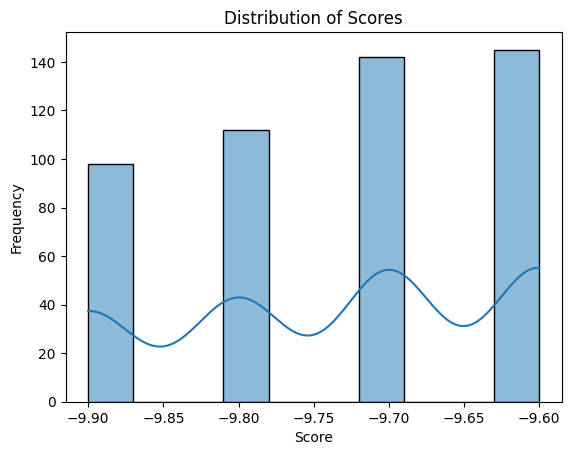

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nedd to change diltered_df
sns.histplot(filtered_df_top_50k['score'], kde=True)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.DataStructs import BulkTanimotoSimilarity
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Morgan fingerprint
def calculate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return fp

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.DataStructs import BulkTanimotoSimilarity
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Morgan fingerprint
def calculate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return fp

# Load your dataset into a DataFrame (replace 'data.csv.gz' with your file name)
df = filtered_df_50k

# Calculate fingerprints for each molecule
df['Fingerprint'] = df['smiles'].apply(calculate_morgan_fingerprint)

# Remove molecules with None fingerprints
df = df.dropna()

# Calculate pairwise Tanimoto similarity
fingerprints = list(df['Fingerprint'])
similarity_matrix = []
for fp1 in fingerprints:
    similarities = BulkTanimotoSimilarity(fp1, fingerprints)
    similarity_matrix.append(similarities)

# Convert similarity matrix to DataFrame for visualization
similarity_df = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='average')
clustering.fit(similarity_df)

# Add cluster labels to DataFrame
df['Cluster'] = clustering.labels_

# Plot the distribution of Tanimoto similarities
sns.histplot(similarity_df.values.flatten(), bins=50, kde=True)
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Tanimoto Similarity')
plt.show()

In [ ]:
df = filtered_df_50k

In [ ]:
df['Fingerprint'] = df['smiles'].apply(calculate_morgan_fingerprint)

In [ ]:
average_tanimoto = similarity_df.mean().mean()

In [ ]:
average_tanimoto

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.DataStructs import BulkTanimotoSimilarity
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Morgan fingerprint
def calculate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return fp

# Load your dataset into a DataFrame (replace 'data.csv.gz' with your file name)
df = pd.read_csv('/content/molpal/data/REAL_Enamine10k_scores.csv.gz', compression='gzip')

# Calculate fingerprints for each molecule
df['Fingerprint'] = df['smiles'].apply(calculate_morgan_fingerprint)

# Remove molecules with None fingerprints
df = df.dropna()

# Calculate pairwise Tanimoto similarity
fingerprints = list(df['Fingerprint'])
similarity_matrix = []
for fp1 in fingerprints:
    similarities = BulkTanimotoSimilarity(fp1, fingerprints)
    similarity_matrix.append(similarities)

# Convert similarity matrix to DataFrame for visualization
similarity_df = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)

# Perform hierarchical clustering
#clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='average')
#clustering.fit(similarity_df)

# Add cluster labels to DataFrame
#df['Cluster'] = clustering.labels_

# Plot the distribution of Tanimoto similarities
sns.histplot(similarity_df.values.flatten(), bins=50, kde=True)
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Tanimoto Similarity')
plt.show()

In [ ]:
average_tanimoto = similarity_df.mean().mean()

In [ ]:
average_tanimoto